## Multiclassifier Test



In [71]:
# Libraries for data manipulation
import pandas as pd
from nptdms import TdmsFile
import numpy as np

# Libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for model evaluation
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

# Machine learning algorithms
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Other libraries
import time
from joblib import dump, load


In [72]:
#Functions Definition

def rename(df):
    df = df.rename(columns={
        "/'Untitled'/'Micr1'": 'Micr1',
        "/'Untitled'/'Acc1X'": 'Acc1X',
        "/'Untitled'/'Acc1Y'": 'Acc1Y',
        "/'Untitled'/'Acc1Z'": 'Acc1Z',
        "/'Untitled'/'Acc5X'": 'Acc5X',
        "/'Untitled'/'Acc5Y'": 'Acc5Y',
        "/'Untitled'/'Acc5Z'": 'Acc5Z',
        "/'Untitled'/'Acc1L'": 'Acc1L',
        "/'Untitled'/'Acc3X'": 'Acc3X',
        "/'Untitled'/'Acc3Y'": 'Acc3Y',
        "/'Untitled'/'Acc3Z'": 'Acc3Z',
        "/'Untitled'/'Acc3L'": 'Acc3L',
        "/'Untitled'/'Acc5L'": 'Acc5L',
        "/'Untitled'/'Acc2L'": 'Acc2L',
        "/'Untitled'/'Acc4L'": 'Acc4L',
        "/'Untitled'/'Mems3'": 'Mems3',
        "/'Untitled'/'Curr1'": 'Curr1',
        "/'Untitled'/'Curr2'": 'Curr2',
        "/'Untitled'/'Curr3'": 'Curr3',
        "/'Untitled'/'Mems5X'": 'Mems5X',
        "/'Untitled'/'Mems5Y'": 'Mems5Y',
        "/'Untitled'/'Mems5Z'": 'Mems5Z',
        "/'Untitled'/'SlowShaftTrigger'": 'SlowShaftTrigger'
    })
    return df

def createPandasDF(df):
    df = df.dropna()
    df = rename(df)
    df = df.drop(df.columns[-1], axis=1)
    return df

def toBinned(df):

    bin_size = 440
    
   # Initialize an empty dictionary to store the results of binning for each column
binned_data = {}

# Iterate over all columns to be binned
for col in df.columns:
    # Perform binning by grouping by bin_size
    binned_col = df[col].groupby(df.index // bin_size)

    # Calculate the statistics for each bin
    binned_stats = binned_col.agg(['mean', 'skew', 'var'])

    # Rename the resulting columns based on the column and metric used
    binned_stats.columns = [f'{col}_{stat}_binned' for stat in ['mean', 'skew', 'var']]

    # Add the results to the dictionary
    binned_data[col] = binned_stats

# Create a new DataFrame with all the binned columns
binned_df = pd.concat(binned_data.values(), axis=1)

    return binned_df


In [73]:
def df_from_path(file_paths):
    # Create an empty list for the DataFrames
    df_out = []

    # Loop through each TDMS file and create the corresponding DataFrame
    for file_path in file_paths:
        full_path = '/PROVE_Nastro/Dati campionati' + file_path  
        tdms_file = TdmsFile.read(full_path)
        df = tdms_file.as_dataframe()
        df = createPandasDF(df)
        #    df = df.sample(frac=0.65, random_state=42)
        df_out.append(df)
    df_output = pd.concat(df_out, ignore_index=True)
    return df_output

# For the binary classifier
def addError(df, error):
    if error:
        df['Error'] = 1
    else:
        df['Error'] = 0
    return df


# For the multiclass classifier
def addMultiError(df, type):
    df['Error'] = type
    return df


def checkLength(df,dim):
    maxDim = len(df)
    if dim < 0:
        print("Error: the dimension of the dataframe cannot be negative!")
        return df, 0
    elif dim >= maxDim:
        return df, maxDim
    else: return df, dim
        
    
def concat_DF(binned_nom, dimNom, binned_Loops, dimLoops, binned_Chain, dimChain, binned_Ties, dimTies):
    binned_nom, dimNom = checkLength(binned_nom, dimNom)
    binned_Loops, dimLoops = checkLength(binned_Loops, dimLoops)
    binned_Chain, dimChain = checkLength(binned_Chain, dimChain)
    binned_Ties, dimTies = checkLength(binned_Ties, dimTies)

    concatenated_df = pd.concat([binned_nom.head(dimNom), binned_Loops.head(dimLoops), binned_Chain.head(dimChain), binned_Ties.head(dimTies)], axis=0)
    concatenated_df.reset_index(drop=True, inplace=True)
    
    return concatenated_df


In [74]:
# Elenco dei file non utilizzati nel model, per fare test
file_paths_Test_nom = [
    "/Nominal/NONdata_Test39_0007_sampled.tdms",
    "/Nominal/NONdata_Test40_0003_Nominal_sampled_Test2.tdms"
]

file_paths_Test_Loops = [
    "/Loops/data_Test23_0003_sampled.tdms",
]

file_paths_Test_Chain = [
    "/Chain/data_Test41_0006_cat1_sampled_Test.tdms",

]

file_paths_Test_Ties = [
    "/Ties/data_Test38_0005_sampled.tdms",
    "/Ties/data_Test38_0002_sampled.tdms"
]

In [75]:
df_Nominal_Test_bin = df_from_path(file_paths_Test_nom)
binned_nom_Test_bin = toBinned(df_Nominal_Test_bin)
binned_nom_Test_bin = addError(binned_nom_Test_bin, error = False)

df_Loops_Test_bin = df_from_path(file_paths_Test_Loops)
binned_Loops_Test_bin = toBinned(df_Loops_Test_bin)
binned_Loops_Test_bin = addError(binned_Loops_Test_bin, error = True)

df_Chain_Test_bin = df_from_path(file_paths_Test_Chain)
binned_Chain_Test_bin = toBinned(df_Chain_Test_bin)
binned_Chain_Test_bin = addError(binned_Chain_Test_bin,True)

df_Ties_Test_bin = df_from_path(file_paths_Test_Ties)
binned_Ties_Test_bin = toBinned(df_Ties_Test_bin)
binned_Ties_Test_bin = addError(binned_Ties_Test_bin,True)

dimNomTest_bin = 9999       #Max = 2728
dimLoopsTest_bin = 9999     #Max = 1364
dimChainTest_bin = 9999    #Max = 1364
dimTiesTest_bin = 9999  #Max = 2727

concatenated_DF_Test_bin = concat_DF(binned_nom_Test_bin, dimNomTest_bin, binned_Loops_Test_bin, dimLoopsTest_bin, binned_Chain_Test_bin, dimChainTest_bin, binned_Ties_Test_bin, dimTiesTest_bin)

concatenated_DF_Test_bin

,Micr1_mean_binned,Micr1_skew_binned,Micr1_var_binned,Acc1X_mean_binned,Acc1X_skew_binned,Acc1X_var_binned,Acc1Y_mean_binned,Acc1Y_skew_binned,Acc1Y_var_binned,Acc1Z_mean_binned,...,Mems5X_mean_binned,Mems5X_skew_binned,Mems5X_var_binned,Mems5Y_mean_binned,Mems5Y_skew_binned,Mems5Y_var_binned,Mems5Z_mean_binned,Mems5Z_skew_binned,Mems5Z_var_binned,Error
0,-0.083897,0.056079,4.200143,0.061012,0.063891,1.095064,0.019497,-0.321420,5.372321,0.015456,...,1.600279,-0.053313,0.001478,1.652722,-0.103073,0.001138,1.689649,0.086801,0.000352,0
1,-0.058107,-0.212833,4.322058,0.067004,-0.434588,0.867724,0.116357,-0.298988,9.019157,-0.002639,...,1.600168,-0.121334,0.002231,1.651884,-0.007463,0.001279,1.687530,0.159070,0.000426,0
2,0.110967,-0.200941,4.040246,0.060804,-0.125057,1.198394,0.029822,-1.479759,9.511026,0.013312,...,1.600526,-0.420678,0.002201,1.652476,-0.078863,0.000909,1.688851,0.041686,0.000437,0
3,0.085738,0.138794,4.002682,0.056525,-0.497743,1.243351,-0.015248,-1.654333,8.179605,0.017833,...,1.600671,-0.121541,0.002301,1.654191,0.148375,0.001267,1.689411,-0.161553,0.000534,0
4,0.027305,-0.109705,3.910961,0.059444,0.257401,0.993120,0.059200,-2.497712,6.165367,0.007906,...,1.600833,-0.076723,0.002697,1.652977,-0.004322,0.001661,1.690215,-0.336471,0.000362,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8179,-0.126654,-0.270199,3.926588,0.053794,-0.098299,0.908698,0.026433,-0.333526,5.856360,0.012592,...,1.600644,-0.106882,0.001554,1.653747,0.299192,0.000706,1.687573,0.000891,0.000408,1
8180,0.087897,-0.292339,2.574205,0.050169,-0.491750,0.794392,-0.046777,-1.016039,5.386473,0.030831,...,1.601751,0.265181,0.002071,1.654129,0.192166,0.000779,1.690480,1.017023,0.000453,1
8181,0.126007,0.014853,3.709684,0.047910,-0.284028,1.124556,-0.053167,-1.030515,5.453075,0.023099,...,1.600647,0.104920,0.001844,1.652511,0.398610,0.000735,1.687834,0.388901,0.000522,1
8182,0.055168,-0.145570,3.674779,0.051831,-0.532658,0.860534,0.032211,0.770317,6.525885,0.009092,...,1.599755,-0.180041,0.002001,1.653154,-0.035742,0.000793,1.685631,0.887841,0.000486,1


In [76]:
model1 = load('best_model_rfA1.joblib')
mod1 = "RF 1 A"
model2 = load('best_model_rfA2.joblib')
mod2 = "RF 2 A"
model3 = load('best_model_rf1F1.joblib')
mod3 = "RF 1 F1"
model4 = load('best_model_xgb2F1.joblib')
mod4 = "XGB 2 F1"
model5 = load('best_model_xgbA1.joblib')
mod5 = "XGB 1 A"
model6 = load('best_model_xgbA2.joblib')
mod6 = "XGB 2 A"
model7 = load('best_model_xgb1F1.joblib')
mod7 = "XGB 1 F1"
model8 = load('best_model_rf2f1.joblib')
mod8 = "XGB 2 F1"
model9 = load('best_model_rf_f1_cv10.joblib')
mod9 = "RF F1 CV10"
model10 = load('best_model_xgbf1_cv10.joblib')
mod10 = "XGB F1 CV10"
model11 = load('best_model_xgbf1_cv15.joblib')
mod11 = "XGB F1 CV15"


models_un_bin = [model1, model2, model3, model4, model5, model6, model7, model8, model9, model10, model11]
names = [mod1, mod2, mod3, mod4, mod5, mod6, mod7, mod8, mod9, mod10, mod11]

model1_balanced = load('best_model_rf1F1_balanced.joblib')
model2_balanced = load('best_model_rf1A_balanced.joblib')
model3_balanced = load('best_model_rf2f1_balanced.joblib')
model4_balanced = load('best_model_rf2A_balanced.joblib')
model5_balanced = load('best_model_xgbA1_balanced.joblib')
model6_balanced = load('best_model_xgbF11_balanced.joblib')
model7_balanced = load('best_model_xgbA2_balanced.joblib')
model8_balanced = load('best_model_xgb2F1_balanced.joblib')
model9_balanced = load('best_model_rf1_cv10_balanced.joblib')
model10_balanced = load('best_model_xgb_cv10_balanced.joblib')
model11_balanced = load('best_model_xgbf1_cv15_balanced.joblib')

mod1_bal= 'RF1 F1 BAL'
mod2_bal = 'RF1 A1 BAL'
mod3_bal = 'RF2 F1 BAL' 
mod4_bal = 'RF2 A BAL' 
mod5_bal = 'XGB1 A BAL' 
mod6_bal = 'XGB1 F1 BAL' 
mod7_bal = 'XGB2 A BAL' 
mod8_bal = 'XGB2 F1 BAL'
mod9_bal = 'RF1 CV10 BAL'
mod10_bal = 'XGB F1 CV10 BAL'
mod11_bal = 'XGB F1 CV15 BAL'

names_bal = [mod1_bal, mod2_bal, mod3_bal, mod4_bal, mod5_bal, mod6_bal, mod7_bal, mod8_bal, mod9_bal, mod10_bal, mod11_bal]
                
models_balanced_bin = [model1_balanced, #RF1 F1
                    model2_balanced, #RF1 A
                    model3_balanced, #RF2 F1
                    model4_balanced, #RF2 A
                    model5_balanced, #XGB1 A
                    model6_balanced, #XGB1 F1
                    model7_balanced, #XGB2 A
                    model8_balanced, #XGB2 F1
                    model9_balanced, #RF1 CV10
                    model10_balanced, #XGB F1 CV10
                    model11_balanced #XGB F1 CV15
                   ]

In [77]:
# Remove target column (Error) from features
X_Test = concatenated_DF_Test_bin.drop('Error', axis=1)

Classification Report for model 1: 
RF 1 A
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2728
           1       1.00      1.00      1.00      5456

    accuracy                           1.00      8184
   macro avg       1.00      1.00      1.00      8184
weighted avg       1.00      1.00      1.00      8184

Confusion Matrix
[[2728    0]
 [  20 5436]]


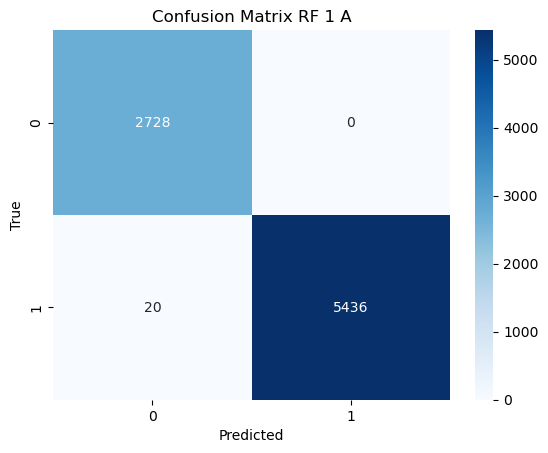

Classification Report for model 2: 
RF 2 A
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2728
           1       1.00      1.00      1.00      5456

    accuracy                           1.00      8184
   macro avg       1.00      1.00      1.00      8184
weighted avg       1.00      1.00      1.00      8184

Confusion Matrix
[[2728    0]
 [  11 5445]]


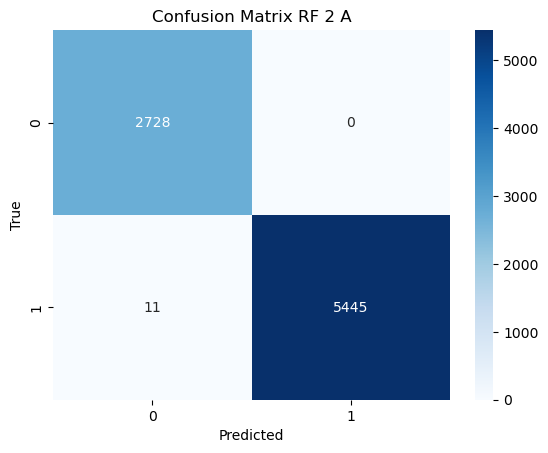

Classification Report for model 3: 
RF 1 F1
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2728
           1       1.00      1.00      1.00      5456

    accuracy                           1.00      8184
   macro avg       1.00      1.00      1.00      8184
weighted avg       1.00      1.00      1.00      8184

Confusion Matrix
[[2728    0]
 [  20 5436]]


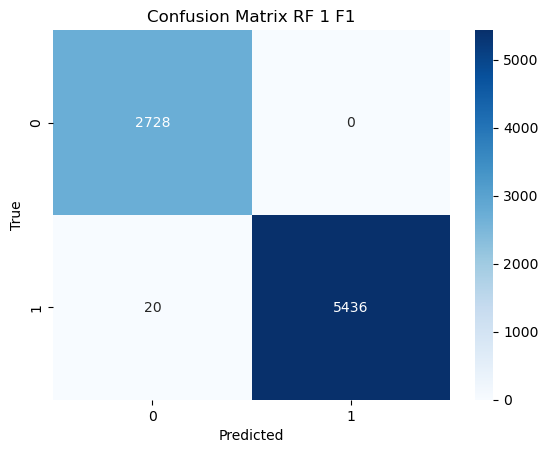

Classification Report for model 4: 
XGB 2 F1
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2728
           1       1.00      0.99      0.99      5456

    accuracy                           0.99      8184
   macro avg       0.99      0.99      0.99      8184
weighted avg       0.99      0.99      0.99      8184

Confusion Matrix
[[2728    0]
 [  66 5390]]


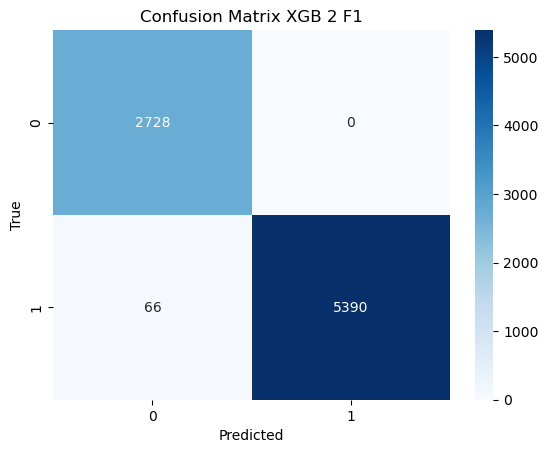

Classification Report for model 5: 
XGB 1 A
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2728
           1       1.00      0.99      1.00      5456

    accuracy                           1.00      8184
   macro avg       0.99      1.00      0.99      8184
weighted avg       1.00      1.00      1.00      8184

Confusion Matrix
[[2728    0]
 [  38 5418]]


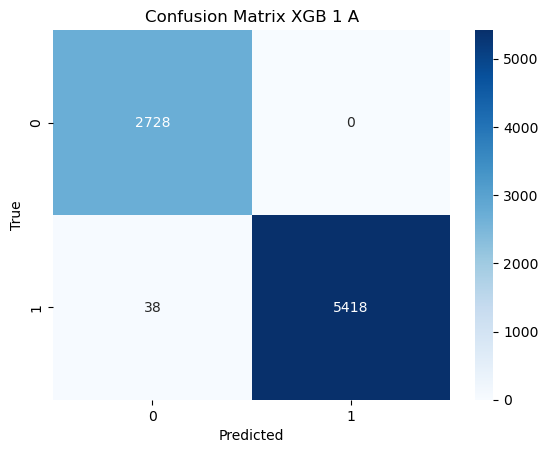

Classification Report for model 6: 
XGB 2 A
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2728
           1       1.00      0.99      0.99      5456

    accuracy                           0.99      8184
   macro avg       0.99      0.99      0.99      8184
weighted avg       0.99      0.99      0.99      8184

Confusion Matrix
[[2728    0]
 [  66 5390]]


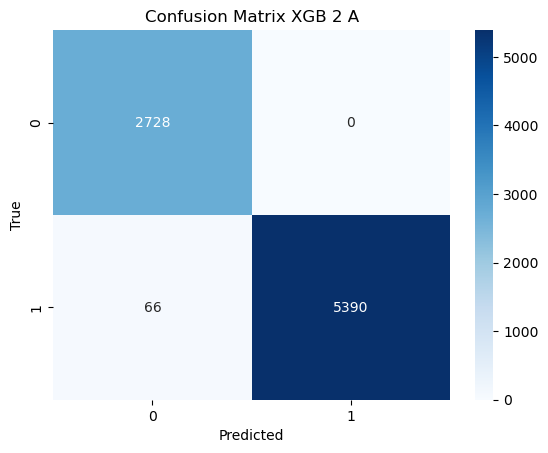

Classification Report for model 7: 
XGB 1 F1
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2728
           1       1.00      0.99      1.00      5456

    accuracy                           1.00      8184
   macro avg       0.99      1.00      0.99      8184
weighted avg       1.00      1.00      1.00      8184

Confusion Matrix
[[2728    0]
 [  38 5418]]


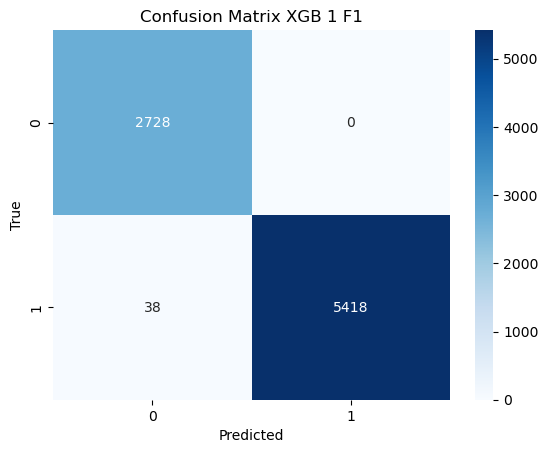

Classification Report for model 8: 
XGB 2 F1
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2728
           1       1.00      1.00      1.00      5456

    accuracy                           1.00      8184
   macro avg       1.00      1.00      1.00      8184
weighted avg       1.00      1.00      1.00      8184

Confusion Matrix
[[2728    0]
 [  11 5445]]


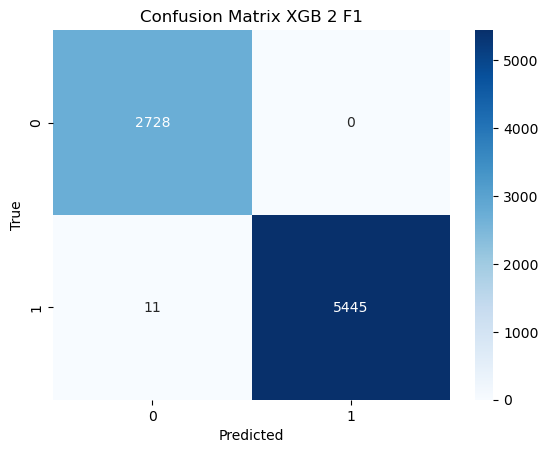

Classification Report for model 9: 
RF F1 CV10
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2728
           1       1.00      1.00      1.00      5456

    accuracy                           1.00      8184
   macro avg       1.00      1.00      1.00      8184
weighted avg       1.00      1.00      1.00      8184

Confusion Matrix
[[2728    0]
 [  19 5437]]


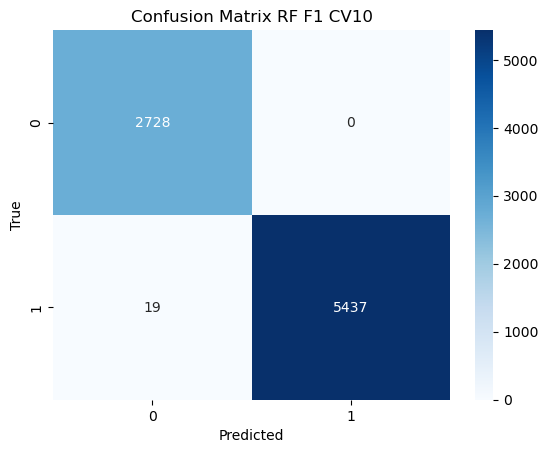

Classification Report for model 10: 
XGB F1 CV10
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2728
           1       1.00      0.99      1.00      5456

    accuracy                           1.00      8184
   macro avg       0.99      1.00      0.99      8184
weighted avg       1.00      1.00      1.00      8184

Confusion Matrix
[[2728    0]
 [  40 5416]]


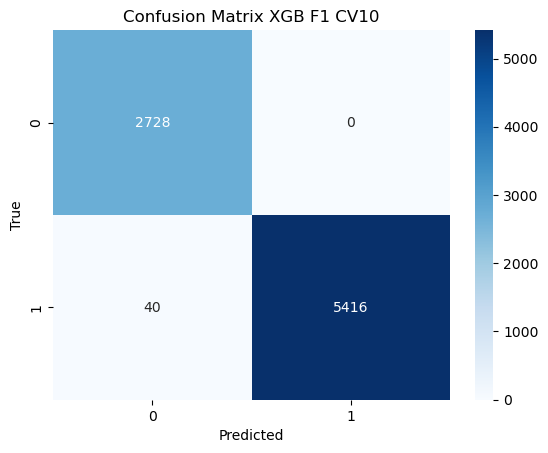

Classification Report for model 11: 
XGB F1 CV15
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2728
           1       1.00      0.99      0.99      5456

    accuracy                           0.99      8184
   macro avg       0.99      0.99      0.99      8184
weighted avg       0.99      0.99      0.99      8184

Confusion Matrix
[[2728    0]
 [  66 5390]]


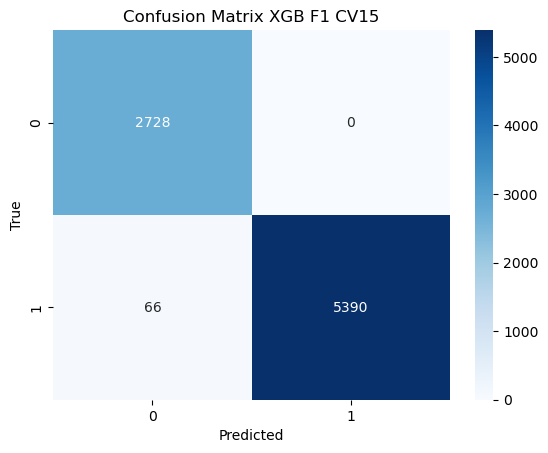

In [78]:
i = 0
for model in models_un_bin:

    # Get the model predictions
    predictions = model.predict(X_Test)

    # Calculate and print classification report
    report_Test = classification_report(concatenated_DF_Test_bin['Error'], predictions)

    print(f"Classification Report for model {i+1}: \n{names[i]}")
    print(report_Test)
    
    # Calculate and print the confusion matrix using seaborn
    confusion_mat = confusion_matrix(concatenated_DF_Test_bin['Error'], predictions)
    print("Confusion Matrix")
    print(confusion_mat)

    # Display confusion matrix
    plt.figure()
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix {names[i]}')
    plt.show()
    i+=1


Classification Report - Modello 1
RF1 F1 BAL
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2728
           1       1.00      1.00      1.00      5456

    accuracy                           1.00      8184
   macro avg       1.00      1.00      1.00      8184
weighted avg       1.00      1.00      1.00      8184

Confusion Matrix
[[2728    0]
 [  18 5438]]


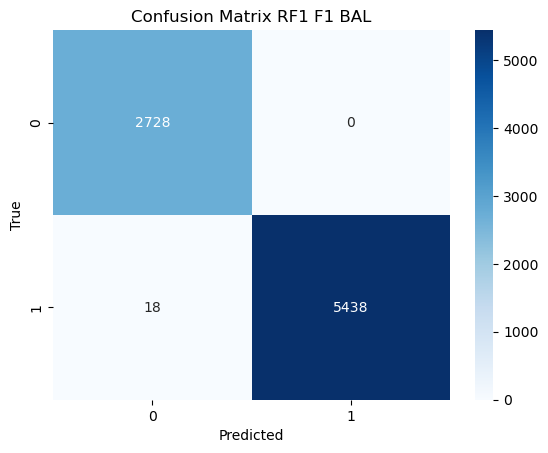

Classification Report - Modello 2
RF1 A1 BAL
              precision    recall  f1-score   support

           0       0.79      1.00      0.89      2728
           1       1.00      0.87      0.93      5456

    accuracy                           0.91      8184
   macro avg       0.90      0.94      0.91      8184
weighted avg       0.93      0.91      0.92      8184

Confusion Matrix
[[2728    0]
 [ 705 4751]]


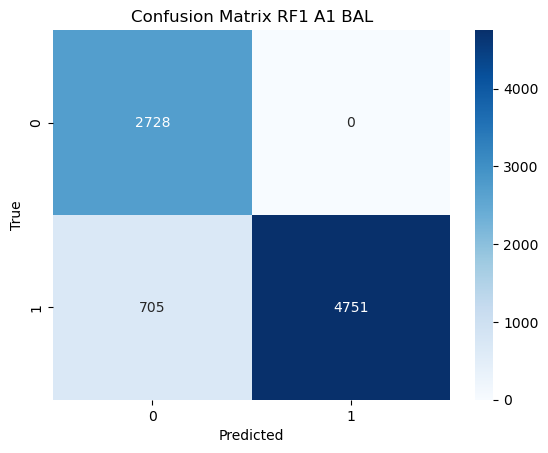

Classification Report - Modello 3
RF2 F1 BAL
              precision    recall  f1-score   support

           0       0.79      1.00      0.89      2728
           1       1.00      0.87      0.93      5456

    accuracy                           0.91      8184
   macro avg       0.90      0.94      0.91      8184
weighted avg       0.93      0.91      0.92      8184

Confusion Matrix
[[2728    0]
 [ 706 4750]]


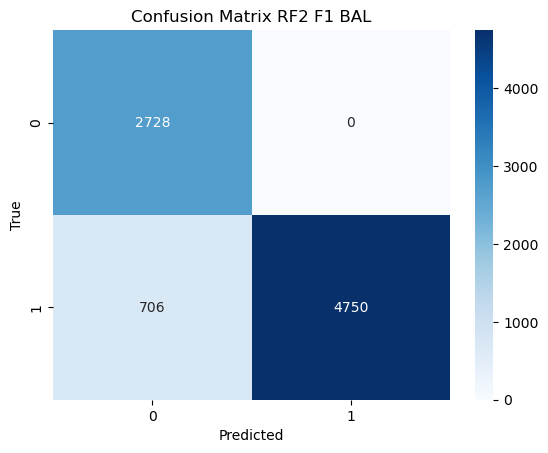

Classification Report - Modello 4
RF2 A BAL
              precision    recall  f1-score   support

           0       0.79      1.00      0.89      2728
           1       1.00      0.87      0.93      5456

    accuracy                           0.91      8184
   macro avg       0.90      0.94      0.91      8184
weighted avg       0.93      0.91      0.92      8184

Confusion Matrix
[[2728    0]
 [ 706 4750]]


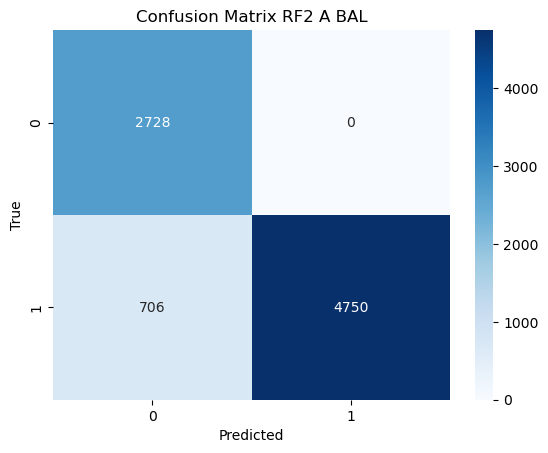

Classification Report - Modello 5
XGB1 A BAL
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      2728
           1       1.00      0.89      0.94      5456

    accuracy                           0.93      8184
   macro avg       0.91      0.95      0.92      8184
weighted avg       0.94      0.93      0.93      8184

Confusion Matrix
[[2728    0]
 [ 586 4870]]


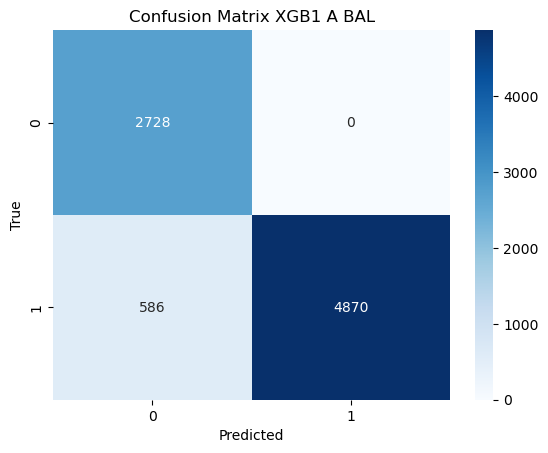

Classification Report - Modello 6
XGB1 F1 BAL
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      2728
           1       1.00      0.89      0.94      5456

    accuracy                           0.93      8184
   macro avg       0.91      0.95      0.92      8184
weighted avg       0.94      0.93      0.93      8184

Confusion Matrix
[[2728    0]
 [ 586 4870]]


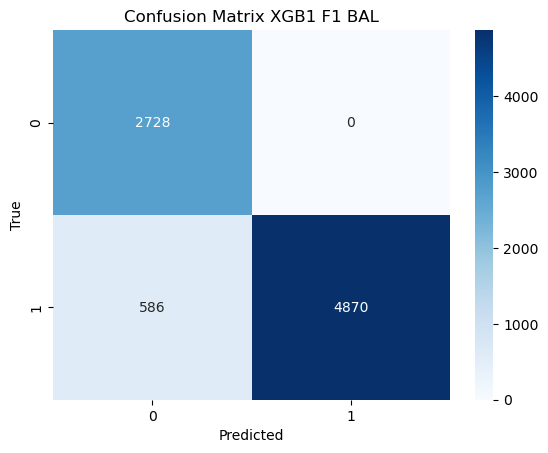

Classification Report - Modello 7
XGB2 A BAL
              precision    recall  f1-score   support

           0       0.70      1.00      0.82      2728
           1       1.00      0.79      0.88      5456

    accuracy                           0.86      8184
   macro avg       0.85      0.89      0.85      8184
weighted avg       0.90      0.86      0.86      8184

Confusion Matrix
[[2728    0]
 [1169 4287]]


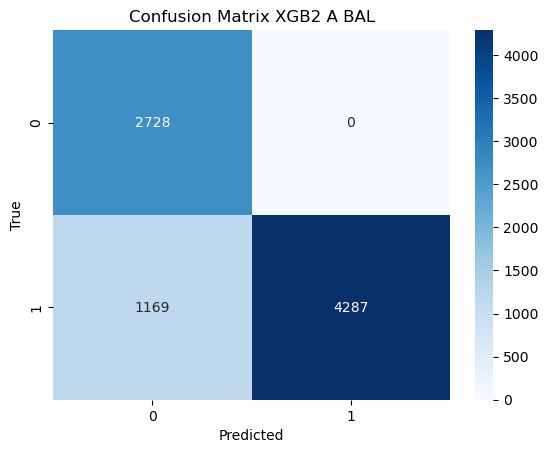

Classification Report - Modello 8
XGB2 F1 BAL
              precision    recall  f1-score   support

           0       0.70      1.00      0.82      2728
           1       1.00      0.79      0.88      5456

    accuracy                           0.86      8184
   macro avg       0.85      0.89      0.85      8184
weighted avg       0.90      0.86      0.86      8184

Confusion Matrix
[[2728    0]
 [1169 4287]]


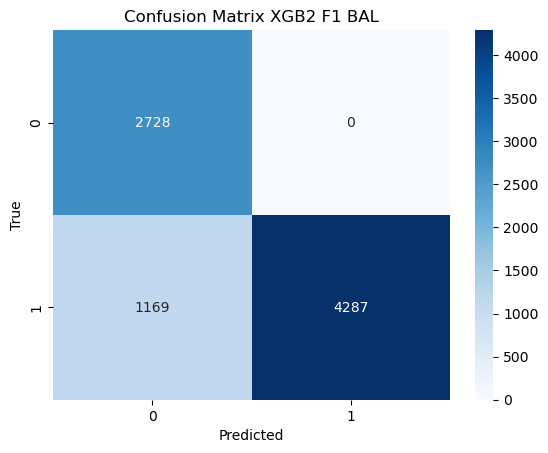

Classification Report - Modello 9
RF1 CV10 BAL
              precision    recall  f1-score   support

           0       0.69      1.00      0.82      2728
           1       1.00      0.78      0.88      5456

    accuracy                           0.85      8184
   macro avg       0.85      0.89      0.85      8184
weighted avg       0.90      0.85      0.86      8184

Confusion Matrix
[[2728    0]
 [1209 4247]]


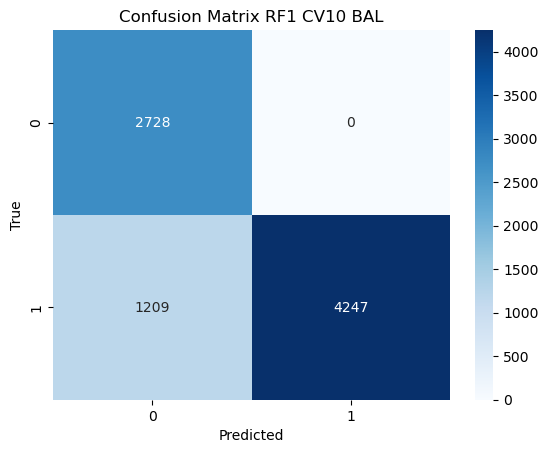

Classification Report - Modello 10
XGB F1 CV10 BAL
              precision    recall  f1-score   support

           0       0.69      1.00      0.82      2728
           1       1.00      0.78      0.88      5456

    accuracy                           0.85      8184
   macro avg       0.85      0.89      0.85      8184
weighted avg       0.90      0.85      0.86      8184

Confusion Matrix
[[2728    0]
 [1209 4247]]


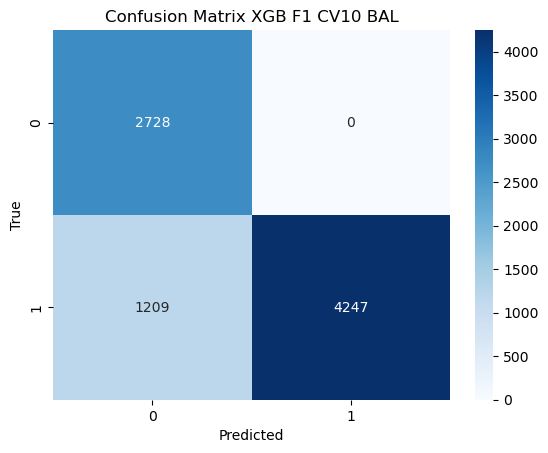

Classification Report - Modello 11
XGB F1 CV15 BAL
              precision    recall  f1-score   support

           0       0.67      1.00      0.80      2728
           1       1.00      0.75      0.86      5456

    accuracy                           0.84      8184
   macro avg       0.84      0.88      0.83      8184
weighted avg       0.89      0.84      0.84      8184

Confusion Matrix
[[2728    0]
 [1337 4119]]


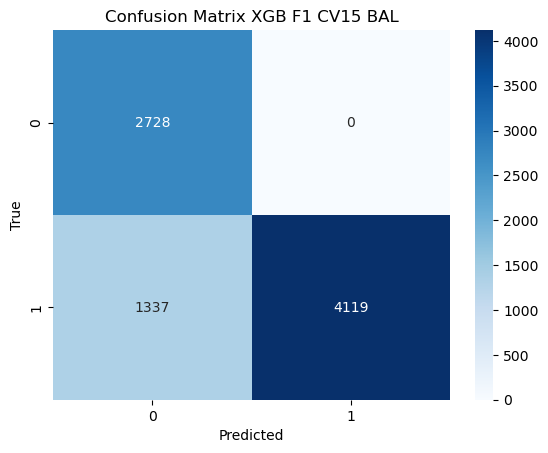

In [79]:
i = 0
for model in models_balanced_bin:

    # Get the model predictions
    predictions = model.predict(X_Test)

    # Calculate and print classification report
    report_Test = classification_report(concatenated_DF_Test_bin['Error'], predictions)
   
    print(f"Classification Report - model {i+1}\n{names_bal[i]}")
    print(report_Test)

    # Calculate and print the confusion matrix using seaborn
    confusion_mat = confusion_matrix(concatenated_DF_Test_bin['Error'], predictions)
    print("Confusion Matrix")
    print(confusion_mat)

    # Display confusion matrix
    plt.figure()
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix {names_bal[i]}')
    plt.show()
    i+=1


#  MULTICLASSIFIER TEST

In [80]:
#For the multiclassifier I use addMultiError, assigning 0 = Nominal, 1,2,3 the three error types

df_Nominal_Test = df_from_path(file_paths_Test_nom)
binned_nom_Test = toBinned(df_Nominal_Test)
binned_nom_Test = addMultiError(binned_nom_Test, type = 0)

df_Loops_Test = df_from_path(file_paths_Test_Loops)
binned_Loops_Test = toBinned(df_Loops_Test)
binned_Loops_Test = addMultiError(binned_Loops_Test, type = 1)

df_Chain_Test = df_from_path(file_paths_Test_Chain)
binned_Chain_Test = toBinned(df_Chain_Test)
binned_Chain_Test = addMultiError(binned_Chain_Test, type = 2)

df_Ties_Test = df_from_path(file_paths_Test_Ties)
binned_Ties_Test = toBinned(df_Ties_Test)
binned_Ties_Test = addMultiError(binned_Ties_Test,type = 3)

dimNomTest = 9999       #Max = 2728
dimLoopsTest = 9999     #Max = 1364
dimChainTest = 9999    #Max = 1364
dimTiesTest = 9999  #Max = 2727

concatenated_DF_Test = concat_DF(binned_nom_Test, dimNomTest, binned_Loops_Test, dimLoopsTest, binned_Chain_Test, dimChainTest, binned_Ties_Test, dimTiesTest)

concatenated_DF_Test

,Micr1_mean_binned,Micr1_skew_binned,Micr1_var_binned,Acc1X_mean_binned,Acc1X_skew_binned,Acc1X_var_binned,Acc1Y_mean_binned,Acc1Y_skew_binned,Acc1Y_var_binned,Acc1Z_mean_binned,...,Mems5X_mean_binned,Mems5X_skew_binned,Mems5X_var_binned,Mems5Y_mean_binned,Mems5Y_skew_binned,Mems5Y_var_binned,Mems5Z_mean_binned,Mems5Z_skew_binned,Mems5Z_var_binned,Error
0,-0.083897,0.056079,4.200143,0.061012,0.063891,1.095064,0.019497,-0.321420,5.372321,0.015456,...,1.600279,-0.053313,0.001478,1.652722,-0.103073,0.001138,1.689649,0.086801,0.000352,0
1,-0.058107,-0.212833,4.322058,0.067004,-0.434588,0.867724,0.116357,-0.298988,9.019157,-0.002639,...,1.600168,-0.121334,0.002231,1.651884,-0.007463,0.001279,1.687530,0.159070,0.000426,0
2,0.110967,-0.200941,4.040246,0.060804,-0.125057,1.198394,0.029822,-1.479759,9.511026,0.013312,...,1.600526,-0.420678,0.002201,1.652476,-0.078863,0.000909,1.688851,0.041686,0.000437,0
3,0.085738,0.138794,4.002682,0.056525,-0.497743,1.243351,-0.015248,-1.654333,8.179605,0.017833,...,1.600671,-0.121541,0.002301,1.654191,0.148375,0.001267,1.689411,-0.161553,0.000534,0
4,0.027305,-0.109705,3.910961,0.059444,0.257401,0.993120,0.059200,-2.497712,6.165367,0.007906,...,1.600833,-0.076723,0.002697,1.652977,-0.004322,0.001661,1.690215,-0.336471,0.000362,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8179,-0.126654,-0.270199,3.926588,0.053794,-0.098299,0.908698,0.026433,-0.333526,5.856360,0.012592,...,1.600644,-0.106882,0.001554,1.653747,0.299192,0.000706,1.687573,0.000891,0.000408,3
8180,0.087897,-0.292339,2.574205,0.050169,-0.491750,0.794392,-0.046777,-1.016039,5.386473,0.030831,...,1.601751,0.265181,0.002071,1.654129,0.192166,0.000779,1.690480,1.017023,0.000453,3
8181,0.126007,0.014853,3.709684,0.047910,-0.284028,1.124556,-0.053167,-1.030515,5.453075,0.023099,...,1.600647,0.104920,0.001844,1.652511,0.398610,0.000735,1.687834,0.388901,0.000522,3
8182,0.055168,-0.145570,3.674779,0.051831,-0.532658,0.860534,0.032211,0.770317,6.525885,0.009092,...,1.599755,-0.180041,0.002001,1.653154,-0.035742,0.000793,1.685631,0.887841,0.000486,3


In [92]:


multiclass1 = load('best_multiclass_xgbA1_bal50.joblib')
m1 = 'XGB 1 Accuracy, 50% '
multiclass2 = load('best_multiclass_xgbf1_bal50.joblib')
m2 = 'XGB 1 F1 score, 50% '
multiclass3 = load('best_multiclissifier_rf1F1_balanced.joblib')
m3 = 'RF 1 F1 score, 50%'
multiclass4 = load('best_multiclassifier_rfA1_balanced.joblib')
m4 = 'RF 1 Accuracy, 50%'
multiclass5 = load('best_multiclass_rf2f1_bal50.joblib')
m5 = 'RF 2 F1 score, 50%'

multiclass1_unb = load('best_multiclass_xgbA1.joblib')
m6 = 'XGB 1 Accuracy'
multiclass2_unb = load('best_multiclass_xgb2A.joblib')
m7 = 'XGB 2 Accuracy'
multiclass3_unb = load('best_multiclass_xgb1f1.joblib')
m8 = 'XGB 1 F1'
multiclass4_unb = load('best_multiclass_xgb2f1.joblib')
m9 = 'XGB 2 F1'


multiclassifier = [ multiclass1, 
                        multiclass2,
                        multiclass3,
                        multiclass4,
                        multiclass5,
                        multiclass1_unb, 
                        multiclass2_unb,
                        multiclass3_unb, 
                        multiclass4_unb,
                      ]

names_multicl= [m1,m2,m3,m4,m5,m6,m7,m8,m9]

In [93]:
# Remove target column (Error) from features
X_Test = concatenated_DF_Test.drop('Error', axis=1)

In [94]:

for i in names_multicl:
    print(i)

XGB 1 Accuracy, 50% 
XGB 1 F1 score, 50% 
RF 1 F1 score, 50%
RF 1 Accuracy, 50%
RF 2 F1 score, 50%
XGB 1 Accuracy
XGB 2 Accuracy
XGB 1 F1
XGB 2 F1


Classification Report for model 1, XGB 1 Accuracy, 50% 
              precision    recall  f1-score   support

           0       0.86      1.00      0.93      2728
           1       0.00      0.00      0.00      1364
           2       0.55      0.98      0.70      1364
           3       1.00      0.95      0.97      2728

    accuracy                           0.81      8184
   macro avg       0.60      0.73      0.65      8184
weighted avg       0.71      0.81      0.75      8184

Confusion Matrix
[[2728    0    0    0]
 [ 268    0 1096    0]
 [  26    0 1338    0]
 [ 136    0    0 2592]]


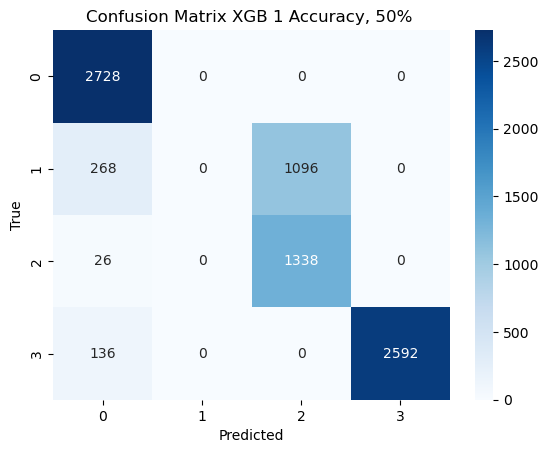

Classification Report for model 2, XGB 1 F1 score, 50% 
              precision    recall  f1-score   support

           0       0.86      1.00      0.93      2728
           1       0.00      0.00      0.00      1364
           2       0.55      0.98      0.70      1364
           3       1.00      0.95      0.97      2728

    accuracy                           0.81      8184
   macro avg       0.60      0.73      0.65      8184
weighted avg       0.71      0.81      0.75      8184

Confusion Matrix
[[2728    0    0    0]
 [ 268    0 1096    0]
 [  26    0 1338    0]
 [ 136    0    0 2592]]


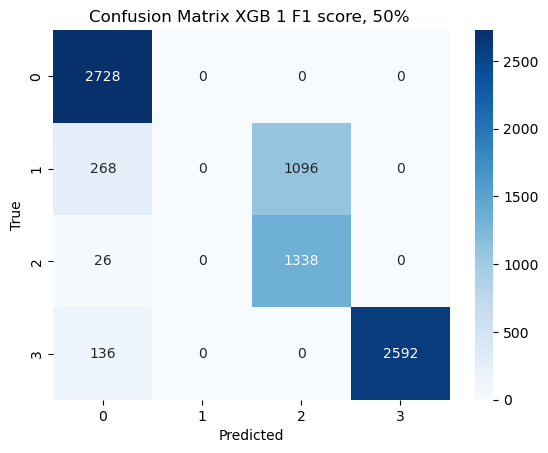

Classification Report for model 3, RF 1 F1 score, 50%
              precision    recall  f1-score   support

           0       0.78      1.00      0.88      2728
           1       0.00      0.00      0.00      1364
           2       0.64      0.98      0.77      1364
           3       1.00      0.95      0.98      2728

    accuracy                           0.81      8184
   macro avg       0.60      0.73      0.66      8184
weighted avg       0.70      0.81      0.75      8184

Confusion Matrix
[[2728    0    0    0]
 [ 598    0  766    0]
 [  31    0 1333    0]
 [ 128    0    0 2600]]


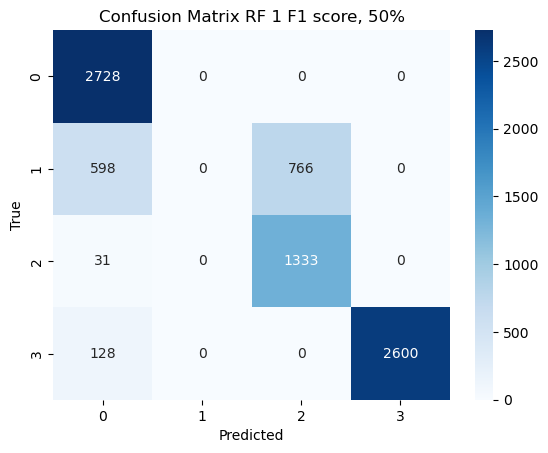

Classification Report for model 4, RF 1 Accuracy, 50%
              precision    recall  f1-score   support

           0       0.78      1.00      0.87      2728
           1       0.00      0.00      0.00      1364
           2       0.63      0.98      0.77      1364
           3       1.00      0.94      0.97      2728

    accuracy                           0.81      8184
   macro avg       0.60      0.73      0.65      8184
weighted avg       0.70      0.81      0.74      8184

Confusion Matrix
[[2728    0    0    0]
 [ 577    0  787    0]
 [  30    0 1334    0]
 [ 173    0    0 2555]]


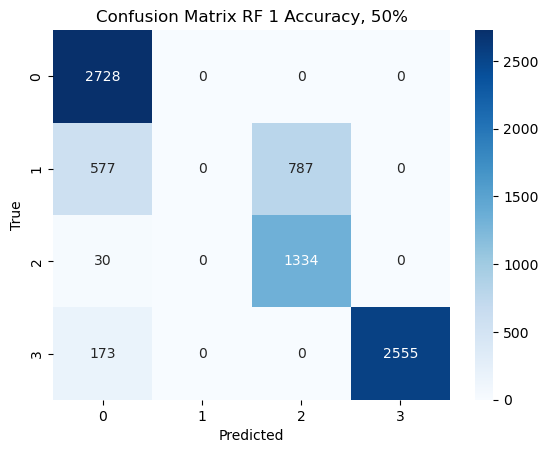

Classification Report for model 5, RF 2 F1 score, 50%
              precision    recall  f1-score   support

           0       0.78      1.00      0.88      2728
           1       0.00      0.00      0.00      1364
           2       0.64      0.98      0.77      1364
           3       1.00      0.96      0.98      2728

    accuracy                           0.82      8184
   macro avg       0.61      0.73      0.66      8184
weighted avg       0.70      0.82      0.75      8184

Confusion Matrix
[[2728    0    0    0]
 [ 615    0  749    0]
 [  30    0 1334    0]
 [ 106    0    0 2622]]


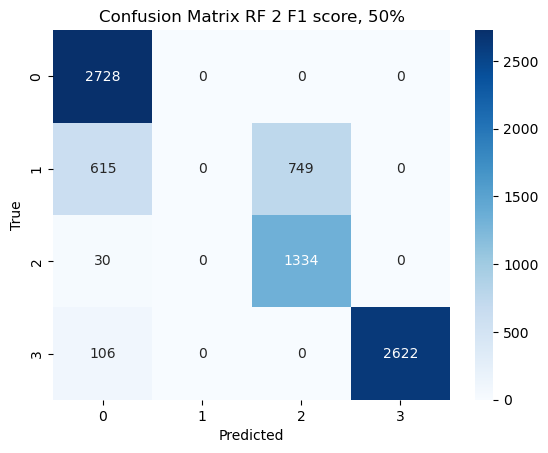

Classification Report for model 6, XGB 1 Accuracy
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2728
           1       0.95      0.98      0.96      1364
           2       0.98      0.97      0.98      1364
           3       1.00      0.97      0.99      2728

    accuracy                           0.98      8184
   macro avg       0.98      0.98      0.98      8184
weighted avg       0.98      0.98      0.98      8184

Confusion Matrix
[[2728    0    0    0]
 [   2 1337   25    0]
 [  34    1 1329    0]
 [   0   69    0 2659]]


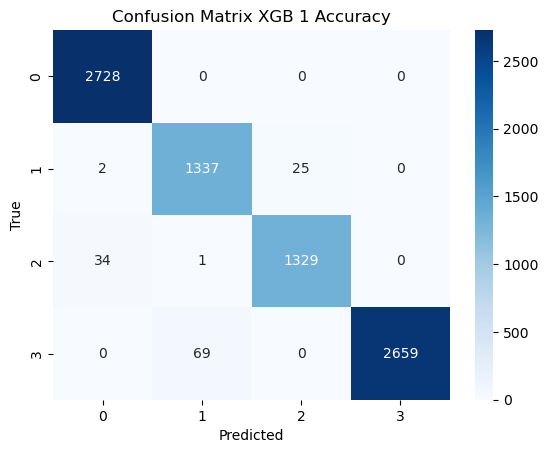

Classification Report for model 7, XGB 2 Accuracy
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2728
           1       0.97      0.94      0.96      1364
           2       0.97      0.97      0.97      1364
           3       1.00      0.99      0.99      2728

    accuracy                           0.98      8184
   macro avg       0.98      0.97      0.98      8184
weighted avg       0.98      0.98      0.98      8184

Confusion Matrix
[[2728    0    0    0]
 [  43 1281   40    0]
 [  45    2 1317    0]
 [   2   31    0 2695]]


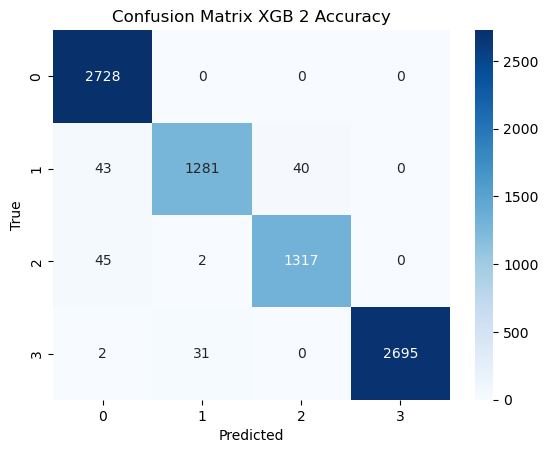

Classification Report for model 8, XGB 1 F1
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2728
           1       0.95      0.98      0.96      1364
           2       0.98      0.97      0.98      1364
           3       1.00      0.97      0.99      2728

    accuracy                           0.98      8184
   macro avg       0.98      0.98      0.98      8184
weighted avg       0.98      0.98      0.98      8184

Confusion Matrix
[[2728    0    0    0]
 [   2 1337   25    0]
 [  34    1 1329    0]
 [   0   69    0 2659]]


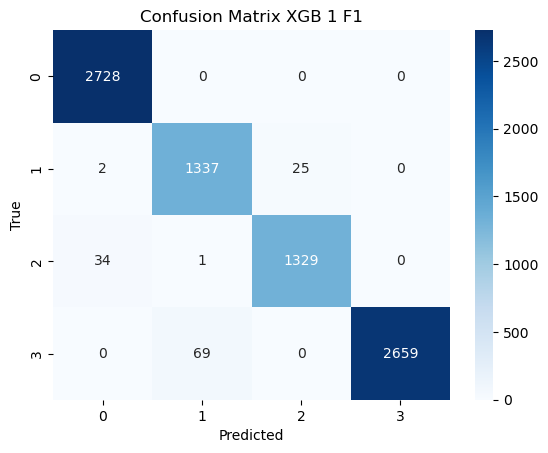

Classification Report for model 9, XGB 2 F1
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2728
           1       0.97      0.94      0.96      1364
           2       0.97      0.97      0.97      1364
           3       1.00      0.99      0.99      2728

    accuracy                           0.98      8184
   macro avg       0.98      0.97      0.98      8184
weighted avg       0.98      0.98      0.98      8184

Confusion Matrix
[[2728    0    0    0]
 [  43 1281   40    0]
 [  45    2 1317    0]
 [   2   31    0 2695]]


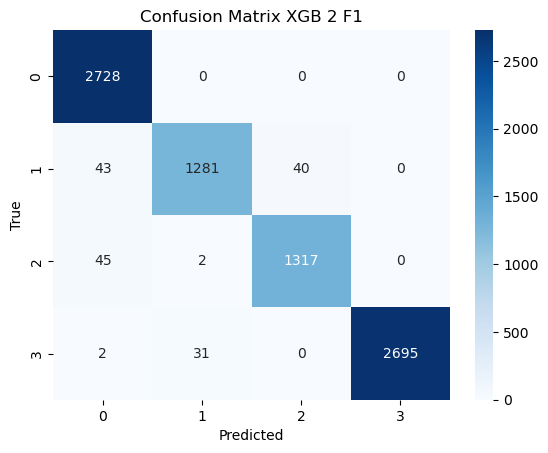

In [96]:
i = 0

for model in multiclassifier:
    # Get the model predictions
    predictions = model.predict(X_Test)

    # Calculate and print classification report
    report_Test = classification_report(concatenated_DF_Test['Error'], predictions, zero_division=0)

    print(f"Classification Report for model {i+1}, {names_multicl[i]}")
    print(report_Test)
    

    # Calculate and print the confusion matrix using seaborn
    confusion_mat = confusion_matrix(concatenated_DF_Test['Error'], predictions)
    print(f"Confusion Matrix")
    print(confusion_mat)

    # Display confusion matrix
    plt.figure()
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix {names_multicl[i]}')
    plt.show()
    i+=1